#  Stochastic Gradient Descent Classifier

<span> This notebook describes a simple TFIDF model that can be used to classify an email as a business or personal email given a corpus from the email's subject body.

### Import Preliminaries


In [66]:
# Import Modules
import os
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import seaborn as sns

# Addititional Import
from matplotlib import rcParams, gridspec
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report,
                             f1_score, precision_score, recall_score,
                             precision_recall_fscore_support, roc_auc_score)
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight

# Warning Configuration
warnings.filterwarnings('ignore')

### Functions

In [4]:
# Grid search groupby function that aggregate grid search data
def grid_search_groupby(results: pd.DataFrame, param_1: str, param_2: str) -> pd.DataFrame:
    '''
    Create a aggregated dataframe from the grid search results use the two
    hyper paramters that we pass into the function. We will be using this
    function to plot heatmaps from our grid search.
    
    Parameters
    ----------
    results: DataFrame of Grid Score results.
    
    Examples
    ----------
    >>> (grid_search_groupby(results,'max_depth','n_estimators')
    >>> grid_search_groupby(results,'max_leaf_nodes','n_estimators')
    '''
    assert (type(results) ==  type(pd.DataFrame())), 'results should be a pandas.core.frame.DataFrame'
    assert (type(param_1) == str), 'param_1 should be a string'
    assert (type(param_2) == str), 'param_2 should be a string'
    
    params_df  = pd.DataFrame.from_dict(list(results.params.values))
    mean_test_score = results.mean_test_score
    result_shrt_df = pd.concat([mean_test_score, params_df], axis=1)
    result_groupby = result_shrt_df.groupby([param_1, param_2])['mean_test_score'].mean().unstack()
    return result_groupby

# Plot a confusion matrix with matplotlib given a confusion matrix
def plot_confusion_matrix(cm, classes, fontsize=20,
                          normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    THE MAIN CONFUSION MATRIX, KAVI DON'T DELTETE BY ACCIDENT AGAIN. Function plots a 
    confusion matrix given a cm matrix and class names

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ---------
    >>>>

    plot_confusion_matrix(
    cm,
    classes,
    fontsize=25,
    normalize=True,
    title=model.name.capitalize() + ': Test Set',
    cmap=plt.cm.Greens)

    '''
    cm_num = cm
    cm_per = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        None
        # print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title.replace('_',' ').title()+'\n', size=fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=fontsize)
    plt.yticks(tick_marks, classes, size=fontsize)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Set color parameters
        color = "white" if cm[i, j] > thresh else "black"
        alignment = "center"

        # Plot perentage
        text = format(cm_per[i, j], '.5f')
        text = text + '%'
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='baseline',
            horizontalalignment='center',
            color=color)
        # Plot numeric
        text = format(cm_num[i, j], 'd')
        text = '\n \n' + text
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='center',
            horizontalalignment='center',
            color=color)

    plt.tight_layout()
    plt.ylabel('True label'.title(), size=fontsize)
    plt.xlabel('Predicted label'.title(), size=fontsize)

    return None

# Confusion matrix plotting function or normal classifier
def plot_confusion_normal(model, classes, name, train_x, train_y,
                          test_x, test_y, cmap=plt.cm.Greens):
    '''
    Fuction plota grid and calls the plot_confusion_matrix function
    to plot two confusion matrices. One for the tarin set and another
    for the test set

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ----------
    >>>> plot_confusion_normal(xg_model, train_x, train_y)
    >>>> plot_confusion_normal(rf_model, train_x, train_y)
    '''

    # Set the plot size
    rcParams['figure.figsize'] = (30.0, 22.5)

    # Set up grid
    plt.figure()
    fig = gridspec.GridSpec(3, 3)
    grid_length = list(range(1, 3))
    tuple_grid = [(i, j) for i in grid_length for j in grid_length]

    # Plot Training Confusion Matrix
    plt.subplot2grid((3, 3), (0, 0))
    cm = confusion_matrix(train_y, model.predict(train_x))
    plot_confusion_matrix(
        cm,
        classes=classes,
        normalize=True,
        title=name.capitalize() + ': Train Set',
        cmap=cmap)

    # Plot Testing Confusion Matrix
    plt.subplot2grid((3, 3), (0, 1))
    cm = confusion_matrix(test_y, model.predict(test_x))
    plot_confusion_matrix(
        cm,
        classes=classes,
        normalize=True,
        title=name.capitalize() + ': Test Set',
        cmap=cmap)

    return None        

# Retrieve email names
def retrieve_email_names(path:str) -> list:
    '''
    This function with search the provided file path and return a
    list of all the files names within path
    
    Parameters
    ----------
    path: a string input specifying the file path
    
    Examples
    ----------
    >>>> retrieve_email_names/kavi/emails/business')
    >>>> retrieve_email_names(/kavi/emails/personal')
    '''
    
    email_names = []
    for root, dirs, files in os.walk(path):
        for file in files:
            email_names.append(file)
    return email_names


# Retriveve email content from directory
def retrieve_email_content(path):
    '''
    This function with search the provided file path and return a 
    list of corpus for all the files witin the directory. Note that
    this function will filter the emails for only the subject lines
    and will note return the email metadata from within this function.
    
    Parameters
    ----------
    path: a string input specifying the file path
    
    Examples
    ---------
    >>>> retrieve_email_content(/kavi/emails/business')
    >>>> retrieve_email_content(/kavi/emails/personal')
    
    '''
    email_content = []
    for root, dirs, files in os.walk(path):
        for file in files:
            file_path = path+'/'+file
            with open(file_path,  encoding='windows-1252') as email_file:
                email = email_file.read()
                start_pos = email.find('\n\n')
                end_pos = email.find('<MARKUP id')
                subject = email[start_pos:end_pos]
                email_content.append(subject)
    return email_content

# Retriveve email date from directory
def retrieve_email_date(path):
    '''
    This function with search the provided file path and return a 
    list of datetime informatioin for all the files witin the directory. 
    Note that this function will filter for only datetime information
    
    Parameters
    ----------
    path: a string input specifying the file path
    
    Examples
    ---------
    >>>> retrieve_email_content(/kavi/emails/business')
    >>>> retrieve_email_content(/kavi/emails/personal')
    
    '''
    email_content = []
    for root, dirs, files in os.walk(path):
        for file in files:
            file_path = path+'/'+file
            with open(file_path,  encoding='windows-1252') as email_file:
                email = email_file.read()
                start_pos = email.find('Date:')
                end_pos = email.find('From:')
                subject = email[start_pos+len('Date:'):end_pos-1]
                email_content.append(subject)
    return email_content

### Import Data

Aggregate all the emails from the business and personal sub directories. Strip any information before the first new line character and everythin after the first `<<MARKUP id=alex...>` HTML tag. When we import the we filter the string for the only the information within the body. Next I strip any unecassary information from the beforing aggregating the data into our training dataset.

In [27]:
# Local File Path to business and personal email data
business = '/Users/kavi/Google Drive/Job/Technical Tests/Behavox/Data/business'
personal = '/Users/kavi/Google Drive/Job/Technical Tests/Behavox/Data/personal'

# Generate a list of files
business_email_names = retrieve_email_names(business)
personal_email_names = retrieve_email_names(personal)
business_email_content = retrieve_email_content(business)
personal_email_content = retrieve_email_content(personal)
business_email_date = retrieve_email_date(business)
personal_email_date = retrieve_email_date(personal)

# Print the length of the returned lists
print('Business Email Name Length:', len(business_email_names))
print('Business Email Concent Length:', len(business_email_content))
print('Personal Email Name Length', len(personal_email_names))
print('Personal EMail Coentent Length', len(personal_email_content))
print('Personal Email Date Length', len(business_email_date))
print('Personal EMail Date Length', len(personal_email_date))

Business Email Name Length: 4871
Business Email Concent Length: 4871
Personal Email Name Length 1855
Personal EMail Coentent Length 1855
Personal Email Date Length 4871
Personal EMail Date Length 1855


In [64]:
# Appending List Data into a Single dataframe
# Targt Values: Business Email = 0, Personal Email = 1
email_target = [0]*len(business_email_names) + [1]*len(personal_email_names)
email_names = business_email_names + personal_email_names
email_content = business_email_content + personal_email_content

# Let Combiine our data into a single dataset
data = pd.DataFrame(data={
    'name': email_names,
    'content': email_content,
    'target': email_target
})

# View the head of the dataframe
data.head()

,name,content,target
0,maildir_cash-m_inbox_287,\n\nMichelle - can you respond? I haven't see...,0
1,maildir_guzman-m_notes_inbox_916,\n\nHey Guys.\n\nBe cautious when doing a NP/M...,0
2,maildir_taylor-m_notes_inbox_1683,\n\nMark:\n\nHere is a draft of what I propose...,0
3,maildir_sanders-r_notes_inbox_182,\n\nAttached is an initial draft of an Agreeme...,0
4,maildir_shackleton-s_notes_inbox_1975,\n\nClint/Sara-\n\nI read the UBS & CSFB confi...,0


### Build Pipelines

In [70]:
# Encode our data into numpy arrays 
X = data.content.values
y = data.target.values

# Train-test split the data
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Compute sample weights
weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [75]:
# Building a simple for the model pipeline 
sgd_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(criterion='gini', 
                                          random_state=42,))], )

### Pipeline Evaluation

In [76]:
# Fit our pipelinee
sgd_pipeline.fit(X_train,y_train, **{'classifier__sample_weight':weights})
sgd_pred = sgd_pipeline.predict(X_train)

In [77]:
# Calculate the cross validation score of the pipeline
scores = cross_validate(sgd_pipeline, X_train, y_train, 
                         cv=10, 
                         fit_params={'classifier__sample_weight':weights},
                         scoring=['accuracy','precision','recall','f1','roc_auc'],)

# Cross validation scores
scores_df = pd.DataFrame(scores).T
scores_df['Mean'] = scores_df.mean(axis=1)
scores_df['Mean']

fit_time           1.134685
score_time         0.432706
test_accuracy      0.887604
train_accuracy     0.994317
test_precision     0.878128
train_precision    0.997905
test_recall        0.691930
train_recall       0.981614
test_f1            0.773463
train_f1           0.989689
test_roc_auc       0.948492
train_roc_auc      0.999884
Name: Mean, dtype: float64

##### Confusion Matrix

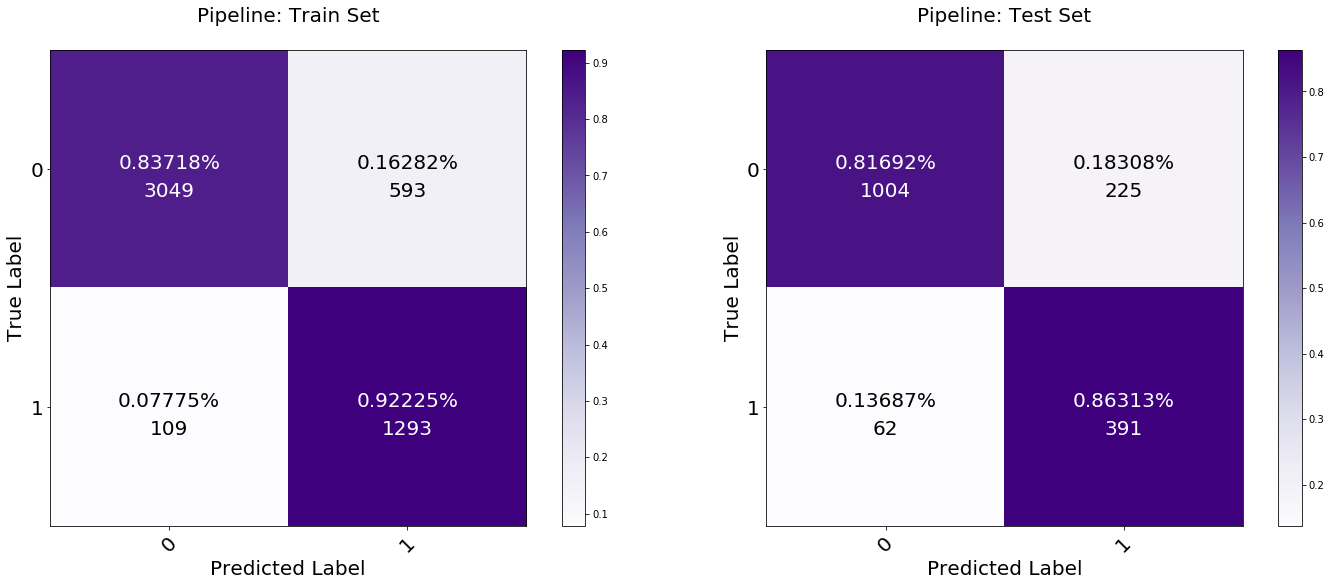

In [74]:
# Plot confusion matrix
plot_confusion_normal(model=sgd_pipeline, classes=[0,1], 
                      name = 'Pipeline',
                      train_x=X_train,
                      test_x=X_test,
                      train_y=y_train, test_y=y_test,
                      cmap= plt.cm.Purples)

##### Pipeline Grid Search

In [11]:
# Setting up the grid
grid = {'classifier__penalty': ['l2','l1','elasticnet',],
        'classifier__loss': ['hinge', 'log', 'modified_huber', 
                             'squared_hinge', 'perceptron'],
        'classifier__alpha':[0.0000001,0.000001,0.00001,
                                0.0001,0.001,0.01,0.1,1]}

# Initialize with GridSearchCV with grid
grid_search = GridSearchCV(estimator=sgd_pipeline, param_grid=grid, 
                     scoring='roc_auc', n_jobs=-1, refit=True, cv=10,
                     return_train_score=True, verbose=0)

# Fit search
grid_search.fit(X,y);

In [12]:
# Print the best grid search score
print('Accuracy of best parameters: %.5f'%grid_search.best_score_)
print('Best parameters: %s' %grid_search.best_params_)

Accuracy of best parameters: 0.98967
Best parameters: {'classifier__alpha': 0.0001, 'classifier__loss': 'hinge', 'classifier__penalty': 'l2'}


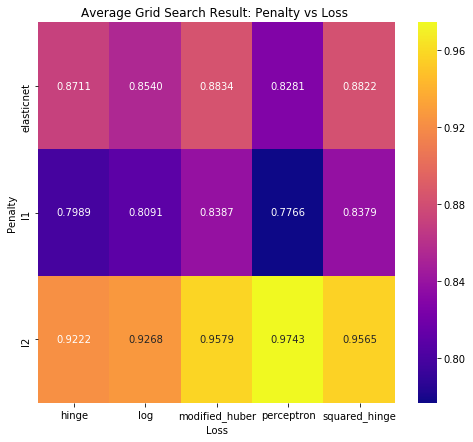

In [13]:
# Plot Grid Seach Results
results = pd.DataFrame(grid_search.cv_results_)
result_groupby_1 = grid_search_groupby(results,
                                       'classifier__penalty',
                                       'classifier__loss')

rcParams['figure.figsize'] = (8.0, 7.0)
sns.heatmap(grid_search_groupby(results,'classifier__penalty',
                                'classifier__loss'),
           cmap='plasma', annot=True, fmt='.4f');
plt.title('Average Grid Search Result: Penalty vs Loss ');
plt.xlabel('Loss')
plt.ylabel('Penalty');

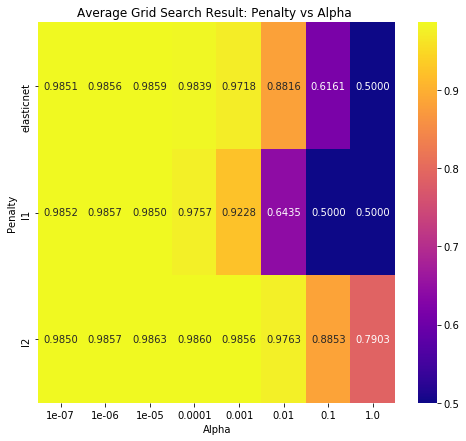

In [14]:
# Plot grid search resutlts
results = pd.DataFrame(grid_search.cv_results_)
result_groupby_1 = grid_search_groupby(results,
                                       'classifier__penalty',
                                       'classifier__alpha')

rcParams['figure.figsize'] = (8.0, 7.0)
sns.heatmap(grid_search_groupby(results,'classifier__penalty',
                                'classifier__alpha'),
           cmap='plasma', annot=True, fmt='.4f');
plt.title('Average Grid Search Result: Penalty vs Alpha ');
plt.xlabel('Alpha')
plt.ylabel('Penalty');

### Final Pipeline

In [15]:
# Print the best model parameters
print('Best parameters: %s' %grid_search.best_params_)

Best parameters: {'classifier__alpha': 0.0001, 'classifier__loss': 'hinge', 'classifier__penalty': 'l2'}


In [16]:
# Building a simple for the model pipeline 
sgd_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=0.0001, random_state=42,
                          max_iter=5, tol=None)),], )

# Compute the cross-validation score for the best model again
scores = cross_validate(sgd_pipeline, X_train, y_train, 
                         cv=10, 
                         fit_params={'classifier__sample_weight':weights},
                         scoring=['accuracy','precision','recall','f1','roc_auc'],)

# Cross validation scores
scores_df = pd.DataFrame(scores).T
scores_df['Mean'] = scores_df.mean(axis=1)
scores_df['Mean']

fit_time           0.844827
score_time         0.475414
test_accuracy      0.963325
train_accuracy     0.995947
test_precision     0.930229
train_precision    0.988507
test_recall        0.942240
train_recall       0.997371
test_f1            0.936093
train_f1           0.992919
test_roc_auc       0.988304
train_roc_auc      0.999864
Name: Mean, dtype: float64

Author: Kavi Sekhon